# Advanced Curve Fitting Notebook

This notebook will analyze the data collected in the `BeamTracking` notebook for samples that are placed between two pieces of glass. This could include a sample between two microscope slides, or a liquid inside of a cuvette.

### Theory

In the `BeamTracking` notebook, we collected data pertaining to the position of the beam center as a function of the rotation angle of the sample. 

From Nemoto (1992), we can model the displacement of the beam from the center (ie. where the beam would be if the sample wasn't there) as the sum of the contributions from the confining material and the sample itself:

$$ \delta(\theta, n_1, n_2) = \left[ d_1 \left( 1 - \frac{n_0 \cos(\theta)}{\sqrt{n_1^2 - n_0^2 \sin^2(\theta)}}\right) + 2 d_2 \left( 1 - \frac{n_0 \cos(\theta)}{\sqrt{n_2^2 - n_0^2 \sin^2(\theta)}}\right) \right] \sin(\theta) $$

Where $n_1$ is the (unknown) index of refraction of our material, $n_2$ is the (known) index of refraction of the glass, $d_1$ is the (known) width of the sample, $d_2$ is the (known) width of a single side of the confining material, and $n_0$ is the index of refraction of air. We can then fit this equation to find a value for $n_1$. Note that we actually fit 3 parameters:

$$ \delta(\theta, \vec a) = a_0 + \left[ d_1 \left( 1 - \frac{n_0 \cos(\theta - a_1)}{\sqrt{a_2^2 - n_0^2 \sin^2(\theta - a_1)}}\right) + 2 d_2 \left( 1 - \frac{n_0 \cos(\theta - a_1)}{\sqrt{n_2^2 - n_0^2 \sin^2(\theta - a_1)}}\right) \right] \sin(\theta - a_1) $$

Where $a_0$ and $a_1$ are arbitrary parameters to account for the stage not being perfectly centered, and $a_2$ is the actual index of refraction that we want.

In the case you are measuring the index of refraction of a liquid in a cuvette, you can also avoid having to know the index of refraction of the confining material by measuring $\delta(\theta)$ both with and without the liquid in the cuvette, and then taking the difference.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11

from scipy.optimize import curve_fit

import pandas as pd

In [14]:
n0 = 1.00029 # Weisstein Eric. Index of Refraction. Wolfram Research. 2005.
n1 = 1.51 # Approximate index of refraction of slide

# Path to the file that we will be reading data from
file = 'data/ruby_flat_700nm.txt'
#file = 'data/bk7_glass.txt'

# The width of the sample in mm
dtot = 2.09 # Width of entire sample
#d2 = 1 # Approximate width of slide
d1 = dtot - 2*d2

In [15]:
# Read the data file
data = pd.read_csv(file)

# Convert to radians and mm
# There may or may not have to be a negative here, not quite sure why
angleArr = -data["angle"] * np.pi / 180
displacementArr = data["gauss_center"] * 1e-3 - np.mean(data["gauss_center"] * 1e-3)

# In case you need to cut away some of the extreme data points because of issues
# with centering/interference
angleArr = angleArr[5:-5]
displacementArr = displacementArr[5:-5]

# Functional form of the displacement as a function of angle,
# including extra parameters for phase and displacement offsets
# Theta should be in radians
def func_form(theta, a0, a1, a2):
    return a0 + d1*np.sin(theta - a1)*(1 - (n0 * np.cos(theta - a1))/np.sqrt(a2**2 - n0**2 * np.sin(theta - a1)**2)) + (dtot-d1)*np.sin(theta - a1)*(1 - (n0 * np.cos(theta - a1))/np.sqrt(n1**2 - n0**2 * np.sin(theta - a1)**2))

In [36]:
dArr = np.linspace(.06, .16, 50)
nArr = np.linspace(1.5, 1.53, 50)

fitNArr = np.zeros([len(dArr), len(nArr)])

for i in range(len(dArr)):
    for j in range(len(nArr)):
        d1 = dArr[i]
        n1 = nArr[j]
        popt, pcov = curve_fit(func_form, angleArr, displacementArr,
                               #method='trf',
                               # Bounds for [displacement offset, phase offset, IoR]
                               bounds=([-6, -np.pi/2 + .01, 1.4], # Lower bound
                                       [6, np.pi/2 - .01, 1.5])) # Upper bound
        fitNArr[i,j] = popt[2]

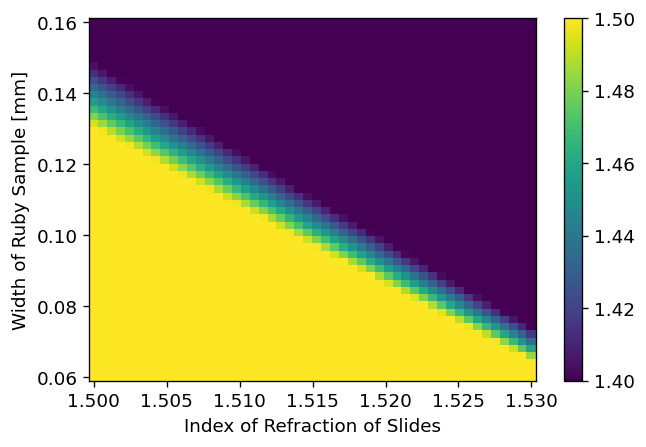

In [40]:
plt.pcolor(nArr, dArr, fitNArr, shading='auto')
plt.ylabel('Width of Ruby Sample [mm]')
plt.xlabel('Index of Refraction of Slides')
plt.colorbar()
plt.savefig('images/ruby_flat_test.png')

Here is where we actually do the fitting; if you suspect that the bounds for fitting below are not sufficient, be sure to change them. As of now, I can't imagine a material that wouldn't fall within these parameter values, but it is possible.

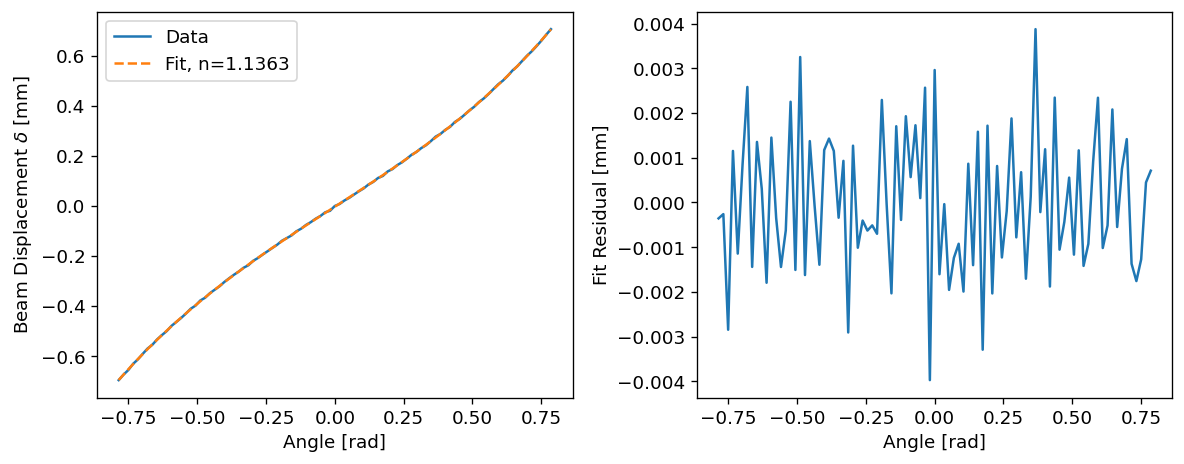

In [37]:
# Now actually do the curve fitting
popt, pcov = curve_fit(func_form, angleArr, displacementArr,
                       #method='trf',
                       # Bounds for [displacement offset, phase offset, IoR]
                       bounds=([-6, -np.pi/2 + .01, 1.0], # Lower bound
                               [6, np.pi/2 - .01, 2.0])) # Upper bound

# Make a pretty plot
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(angleArr, displacementArr, label='Data')
ax[0].plot(angleArr, func_form(angleArr, *popt), '--', label=f'Fit, n={popt[2]:.5}')
ax[0].set_xlabel('Angle [rad]')
ax[0].set_ylabel(r'Beam Displacement $\delta$ [mm]')
ax[0].legend()

ax[1].plot(angleArr, displacementArr - func_form(angleArr, *popt))
ax[1].set_xlabel('Angle [rad]')
ax[1].set_ylabel('Fit Residual [mm]')

#fig.suptitle(f'{file}\nwidth = {d}mm')
fig.tight_layout()
plt.savefig('images/ruby_flat_700nm.png')
plt.show()